### Detección de asteroides peligrosos

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/asteroids.csv')
data.head()



,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [90]:
data.shape

(4687, 40)

## Exploración del dataset

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [92]:
#¿Cuántas filas hay duplicadas?
num_duplicated = data.duplicated().sum()

print('El número de filas duplicadas es: ', num_duplicated)

El número de filas duplicadas es:  0


In [93]:
#Comprobando el número de filas vacías
isnan = data.isna().sum()
print('El número de filas vacías es: ', isnan)

El número de filas vacías es:  Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
Orbiting Body                   0
Orbit ID                        0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis  

In [94]:
data.describe()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,...,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,...,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,...,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,...,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,...,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,...,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,...,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,...,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


In [95]:
#Comprobar si hay filas vacías

isnull_ = data.isnull().sum()

print('El número de filas vacías es: ', isnull_)

El número de filas vacías es:  Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
Orbiting Body                   0
Orbit ID                        0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis  

### Ahora procedo a modificar los valores necesarios para hacer un correcto análisis

In [96]:
data['Hazardous'] = data['Hazardous'].replace({'True':1, 'False':0}).astype(int)
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,1
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,0
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,1
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,0
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,1


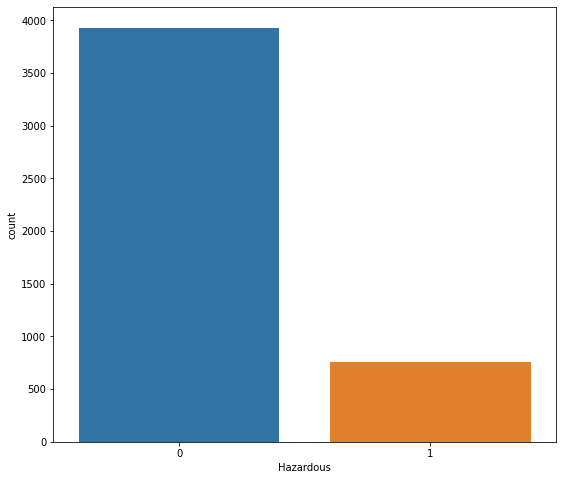

In [97]:
import seaborn as sns
figure=plt.figure(figsize=(9,8))

sns.countplot(x=data['Hazardous'])

Se deduce que la gran mayoría de asteroides regitrados no suponen una amenaza real

Veamos ahora la correlación de las variables con la variable objetivo ('Hazardous')

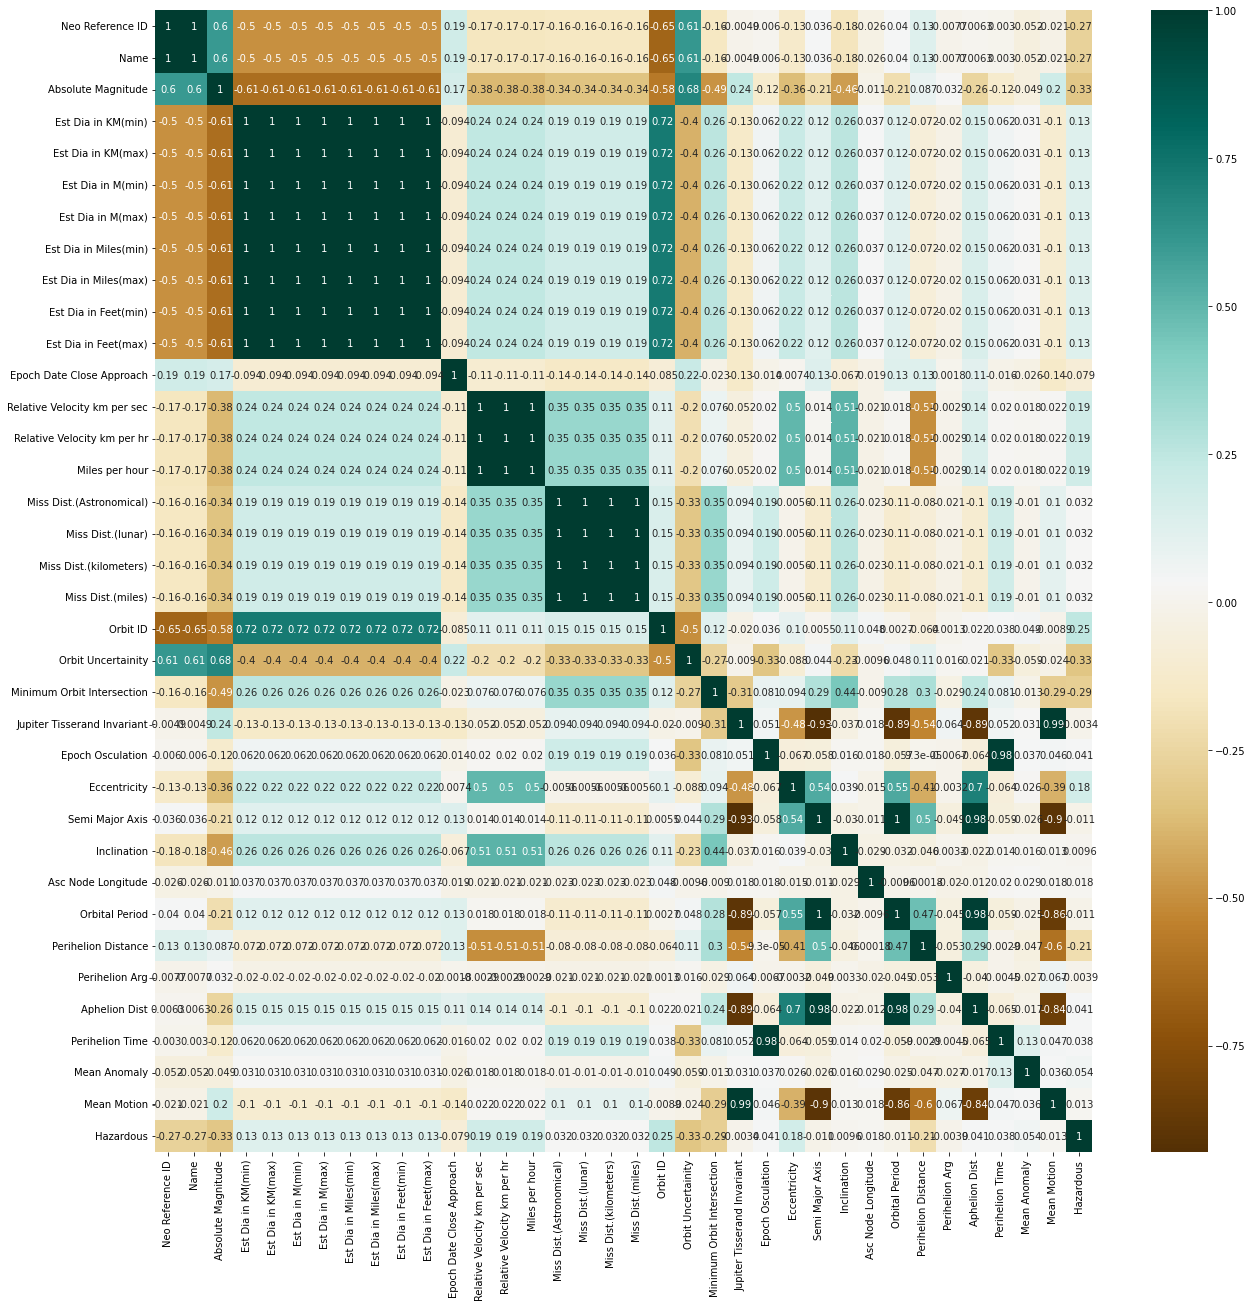

In [98]:

plt.figure(figsize=(21,21))
sns.heatmap(data.corr(),annot=True, cmap='BrBG')

El hecho de que hayan varias variables con correlación unidad es debido a que presentan los mismos valores, por tanto son variables redundantes y nos quedamos con una

In [99]:
data = data.drop(['Neo Reference ID','Name','Orbit ID',
                 'Close Approach Date','Epoch Date Close Approach',
                 'Orbit Determination Date',
                 'Est Dia in KM(min)','Est Dia in KM(max)',
                 'Est Dia in Miles(min)','Est Dia in Miles(max)',
                 'Est Dia in Feet(min)','Est Dia in Feet(max)',
                 'Orbiting Body','Equinox'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Relative Velocity km per hr   4687 non-null   float64
 5   Miles per hour                4687 non-null   float64
 6   Miss Dist.(Astronomical)      4687 non-null   float64
 7   Miss Dist.(lunar)             4687 non-null   float64
 8   Miss Dist.(kilometers)        4687 non-null   float64
 9   Miss Dist.(miles)             4687 non-null   float64
 10  Orbit Uncertainity            4687 non-null   int64  
 11  Minimum Orbit Intersection    4687 non-null   float64
 12  Jupiter Tisserand Invariant   4687 non-null   float64
 13  Epo

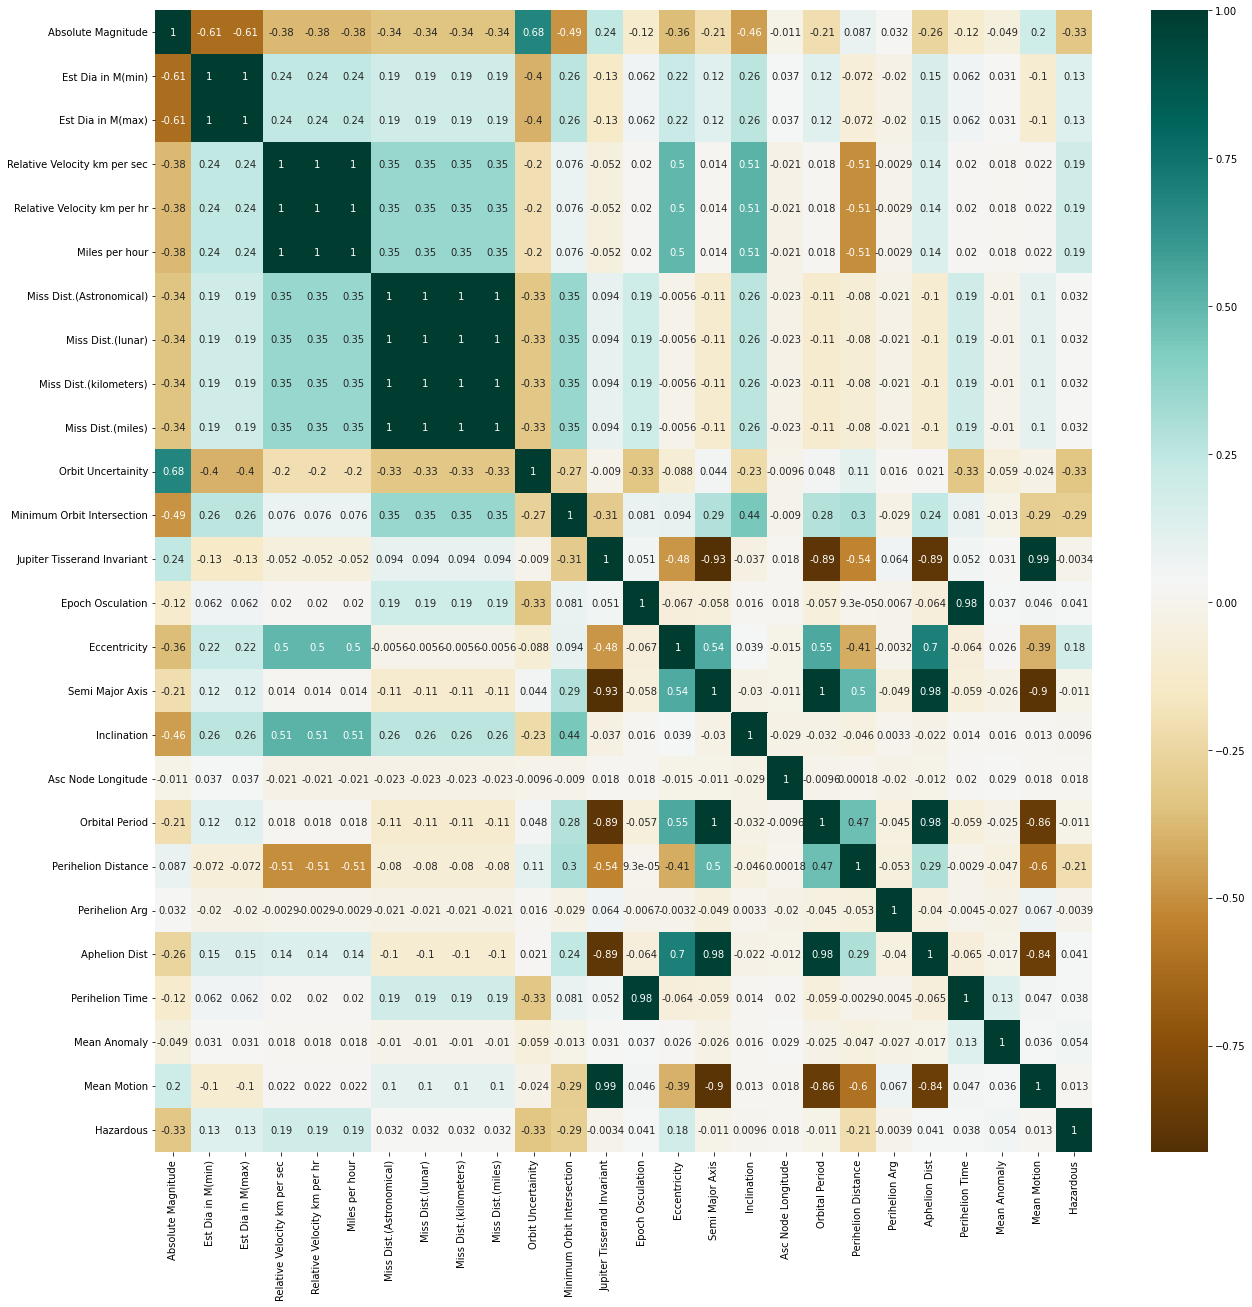

In [100]:

plt.figure(figsize=(21,21))
sns.heatmap(data.corr(),annot=True, cmap='BrBG')

In [101]:
data = data.drop([
                 'Relative Velocity km per hr',
                 'Miles per hour','Miss Dist.(lunar)',
                 'Miss Dist.(kilometers)',
                 'Miss Dist.(miles)'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Miss Dist.(Astronomical)      4687 non-null   float64
 5   Orbit Uncertainity            4687 non-null   int64  
 6   Minimum Orbit Intersection    4687 non-null   float64
 7   Jupiter Tisserand Invariant   4687 non-null   float64
 8   Epoch Osculation              4687 non-null   float64
 9   Eccentricity                  4687 non-null   float64
 10  Semi Major Axis               4687 non-null   float64
 11  Inclination                   4687 non-null   float64
 12  Asc Node Longitude            4687 non-null   float64
 13  Orb

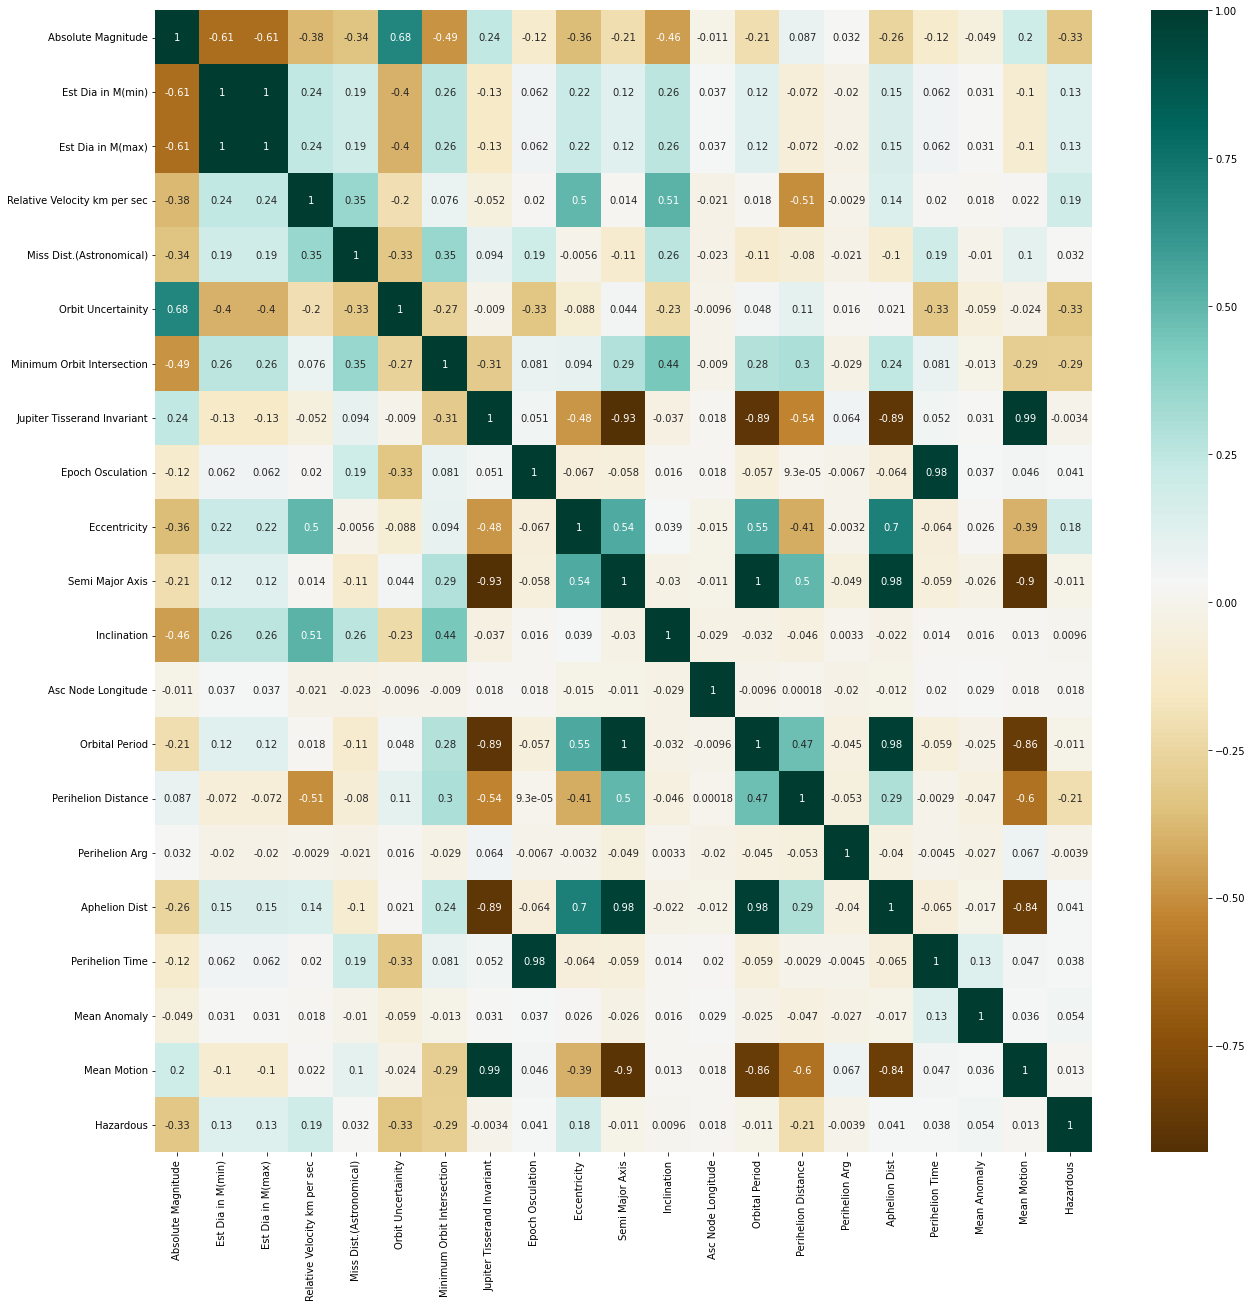

In [102]:

plt.figure(figsize=(21,21))
sns.heatmap(data.corr(),annot=True, cmap='BrBG')

In [ ]:
data

,Absolute Magnitude,Est Dia in M(min),Est Dia in M(max),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.600,127.219879,284.472297,6.115834,0.419483,5,0.025282,4.634,2458000.5,0.425549,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,1
1,21.300,146.067964,326.617897,18.113985,0.383014,3,0.186935,5.457,2458000.5,0.351674,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,0
2,20.300,231.502122,517.654482,7.590711,0.050956,0,0.043058,4.557,2458000.5,0.348248,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,1
3,27.400,8.801465,19.680675,11.173874,0.285322,6,0.005512,5.093,2458000.5,0.216578,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,0
4,21.600,127.219879,284.472297,9.840831,0.407832,1,0.034798,5.154,2458000.5,0.210448,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,23.900,44.111820,98.637028,22.154265,0.041361,8,0.019777,5.156,2457637.5,0.361512,...,39.880491,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436,0
4683,28.200,6.089126,13.615700,3.225150,0.006469,6,0.006451,5.742,2458000.5,0.073200,...,5.360249,345.225230,407.185767,0.996434,42.111064,1.153835,2.458088e+06,282.978786,0.884117,0
4684,22.700,76.657557,171.411509,7.191642,0.061009,6,0.059972,4.410,2458000.5,0.368055,...,4.405467,37.026468,690.054279,0.965760,274.692712,2.090708,2.458300e+06,203.501147,0.521698,0
4685,21.800,116.025908,259.441818,11.352090,0.260760,5,0.177510,4.477,2458000.5,0.202565,...,21.080244,163.802910,662.048343,1.185467,180.346090,1.787733,2.458288e+06,203.524965,0.543767,0


### Construcción del modelo

In [103]:
data_ = data.iloc[:, 1:20]
target_ = data.iloc[:, -1]
data_

,Est Dia in M(min),Est Dia in M(max),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,127.219879,284.472297,6.115834,0.419483,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551
1,146.067964,326.617897,18.113985,0.383014,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330
2,231.502122,517.654482,7.590711,0.050956,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371
3,8.801465,19.680675,11.173874,0.285322,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277
4,127.219879,284.472297,9.840831,0.407832,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,44.111820,98.637028,22.154265,0.041361,8,0.019777,5.156,2457637.5,0.361512,1.161429,39.880491,164.183305,457.179984,0.741558,276.395697,1.581299,2.457708e+06,304.306025,0.787436
4683,6.089126,13.615700,3.225150,0.006469,6,0.006451,5.742,2458000.5,0.073200,1.075134,5.360249,345.225230,407.185767,0.996434,42.111064,1.153835,2.458088e+06,282.978786,0.884117
4684,76.657557,171.411509,7.191642,0.061009,6,0.059972,4.410,2458000.5,0.368055,1.528234,4.405467,37.026468,690.054279,0.965760,274.692712,2.090708,2.458300e+06,203.501147,0.521698
4685,116.025908,259.441818,11.352090,0.260760,5,0.177510,4.477,2458000.5,0.202565,1.486600,21.080244,163.802910,662.048343,1.185467,180.346090,1.787733,2.458288e+06,203.524965,0.543767


In [104]:
from sklearn import svm, model_selection, preprocessing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_, target_, test_size=0.2)

Dado que el conjunto de datos es limpio y no hay valores duplicados, tendremos un análisis bastante preciso. 

Vamos a implementar dos modelos para classificar, XGBoost y KNN

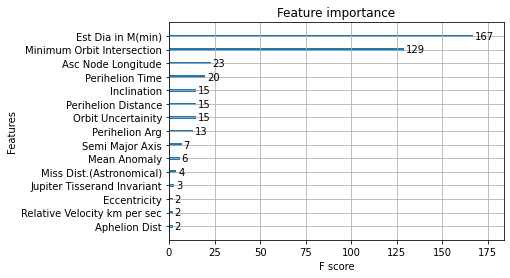

In [105]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

plot_importance(xgb_model)
pyplot.show()

Se ve que el diámetro estimado es la variable más importante a la hora de determinar si un asteroide es peligroso o no.

Otras variables a tener en cuenta son 'Minimum Orbit Intersection' (MOI) y 'Absolute Magnitude', que indica el brillo aparente del objeto. Cuanto menores sean estos valores, mayor es su peligrosidad

In [106]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
prediction = xgb_model.predict(X_test)
acc = accuracy_score(y_test, prediction)
acc1 = str(np.round(acc*100,3)) + '%'
print(acc1)

99.893%


El modelo da una precisión muy alta

In [107]:
class_re = classification_report(y_test, prediction)
print(class_re)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       0.99      1.00      1.00       147

    accuracy                           1.00       938
   macro avg       1.00      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938



In [108]:
print(confusion_matrix(y_test,prediction))

[[790   1]
 [  0 147]]


Analicemos el conjunto con KNN

In [109]:
from sklearn.neighbors import KNeighborsClassifier

In [112]:
hazaryes = data[data['Hazardous'] == 1]
hazarno = data[data['Hazardous'] == 0]
#Servirá después para graficar

In [111]:
classifier = KNeighborsClassifier(n_neighbors=7,metric='minkowski')
classifier.fit(data_,target_)

KNeighborsClassifier(n_neighbors=7)

In [113]:
y_pred_knn = classifier.predict(X_test)

In [114]:
knn_m = KNeighborsClassifier(n_neighbors=7, metric='manhattan')
knn_m.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

In [115]:
#Score of the model using the Minkowski distance
score_minkowski = classifier.score(X_test, y_test)

#Score of the model using the Manhattan distance
score_manhattan = knn_m.score(X_test, y_test)

score_minkowski, score_manhattan

(0.8848614072494669, 0.8432835820895522)

Con la métrica minkowski se obtiene una precisión ligeramente mayor

Procedamos a graficar el conjunto en función de MOI y AM

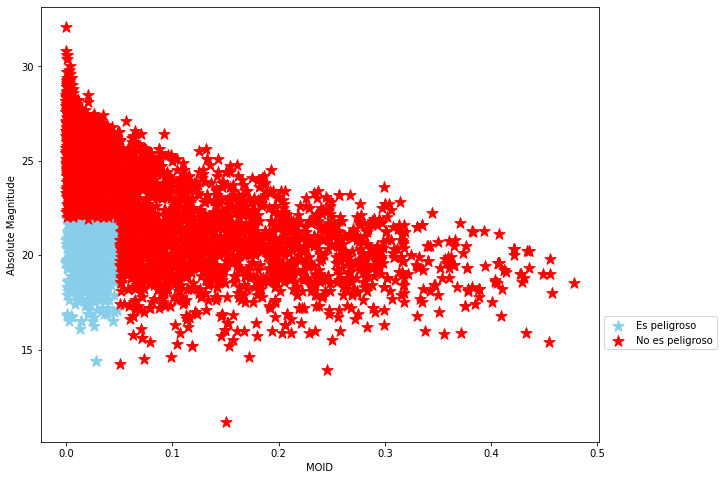

In [117]:

figure = plt.figure(figsize=(10,8))

plt.scatter(hazaryes['Minimum Orbit Intersection'],hazaryes['Absolute Magnitude'],
            marker='*',s=140,color='skyblue',
            label='Es peligroso')

plt.scatter(hazarno['Minimum Orbit Intersection'],hazarno['Absolute Magnitude'],
            marker='*',s=140,color='red',
            label='No es peligroso')

plt.ylabel('Absolute Magnitude')
plt.xlabel('MOID')
plt.legend(bbox_to_anchor=(1,0.3))
plt.show();

Un asteroide cuyo MOID < 0.05 no es peligroso para la Tierra, por tanto se concluye que la clasificación ha sido satisfactoria